In [109]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time

In [110]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)



**Dataset preparation**

In [111]:
#Loading
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data 

x_train= x_train / 255.0
x_test = x_test / 255.0
 
# One-hot encode labels
num_labels = 10
y_train=one_hot(y_train.astype('int32'),num_labels)
y_test=one_hot(y_test.astype('int32'),num_labels)


x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


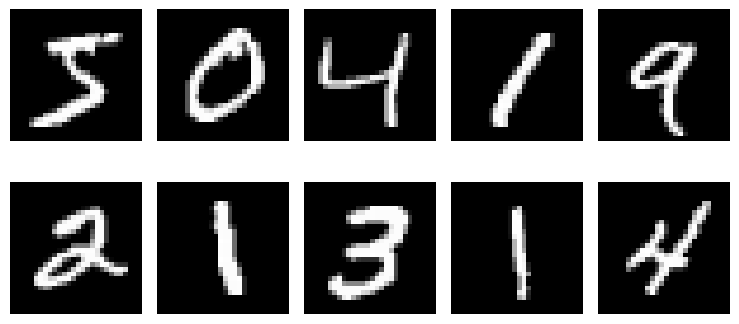

In [112]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

**Initialization**

In [113]:
import numpy as np
import time
import matplotlib.pyplot as plt

class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not supported, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        self.grads = {}
        self.t = 1

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x < 0, 0, 1)
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        if derivative:
            sig = self.sigmoid(x)
            return sig * (1 - sig)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0))  # Numerical stability
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        input_layer, hidden_layer, output_layer = self.sizes
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1. / input_layer),
            "b1": np.zeros((hidden_layer, 1)),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1. / hidden_layer),
            "b2": np.zeros((output_layer, 1)),
        }
        return params

    def initialize_optimizer(self, optimizer):
        if optimizer in ['momentum', 'rmsprop', 'adam']:
            opt = {
                "W1": np.zeros_like(self.params["W1"]),
                "b1": np.zeros_like(self.params["b1"]),
                "W2": np.zeros_like(self.params["W2"]),
                "b2": np.zeros_like(self.params["b2"]),
            }
            if optimizer == "adam":
                return {"m": opt.copy(), "v": opt.copy()}
            return opt
        return None

    def feed_forward(self, x):
        self.cache["X"] = x
        self.cache["Z1"] = np.dot(self.params["W1"], x.T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.dot(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]

    def back_propagate(self, y, output):
        m = y.shape[0]
        dZ2 = output - y.T
        dW2 = (1 / m) * np.dot(dZ2, self.cache["A1"].T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.dot(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1 / m) * np.dot(dZ1, self.cache["X"])
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}

    def optimize(self, l_rate, optimizer, beta1=0.9, beta2=0.999, epsilon=1e-8):
        if optimizer == 'sgd':
            for key in self.params:
                self.params[key] -= l_rate * self.grads[key]
        elif optimizer == 'momentum':
            for key in self.params:
                self.momentum[key] = beta1 * self.momentum[key] + (1 - beta1) * self.grads[key]
                self.params[key] -= l_rate * self.momentum[key]
        elif optimizer == 'rmsprop':
            for key in self.params:
                self.rmsprop[key] = beta2 * self.rmsprop[key] + (1 - beta2) * (self.grads[key] ** 2)
                self.params[key] -= l_rate * self.grads[key] / (np.sqrt(self.rmsprop[key]) + epsilon)
        elif optimizer == 'adam':
            for key in self.params:
                self.adam["m"][key] = beta1 * self.adam["m"][key] + (1 - beta1) * self.grads[key]
                self.adam["v"][key] = beta2 * self.adam["v"][key] + (1 - beta2) * (self.grads[key] ** 2)

                m_hat = self.adam["m"][key] / (1 - beta1 ** self.t)
                v_hat = self.adam["v"][key] / (1 - beta2 ** self.t)
                self.params[key] -= l_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            self.t += 1

    def cross_entropy_loss(self, y, output):
        return -np.mean(np.sum(y * np.log(output.T + 1e-8), axis=1))

    def accuracy(self, y, output):
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(output, axis=0)
        return np.mean(y_true == y_pred)

    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size, optimizer, l_rate=0.01, beta1=0.9, beta2=0.999):
        if optimizer == "momentum":
            self.momentum = self.initialize_optimizer(optimizer)
        elif optimizer == "rmsprop":
            self.rmsprop = self.initialize_optimizer(optimizer)
        elif optimizer == "adam":
            self.adam = self.initialize_optimizer(optimizer)

        train_accuracies = []
        train_losses = []
        test_accuracies = []
        test_losses = []

        for epoch in range(epochs):
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]

                output = self.feed_forward(x_batch)
                self.back_propagate(y_batch, output)
                self.optimize(l_rate, optimizer, beta1, beta2)

            train_output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, train_output)
            train_loss = self.cross_entropy_loss(y_train, train_output)

            test_output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, test_output)
            test_loss = self.cross_entropy_loss(y_test, test_output)

            train_accuracies.append(train_acc)
            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Plotting graphs after training
        self.plot_performance(train_accuracies, test_accuracies, train_losses, test_losses)

    def plot_performance(self, train_accuracies, test_accuracies, train_losses, test_losses):
        epochs = range(1, len(train_accuracies) + 1)

        # Plot Accuracy
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
        plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='x')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, test_losses, label='Test Loss', marker='x')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [114]:
output = dnn.feed_forward(x_train)
print("Output shape:", output.shape)
print("Output sum (should be close to 1):", np.sum(output, axis=0))


Output shape: (10, 60000)
Output sum (should be close to 1): [1. 1. 1. ... 1. 1. 1.]


Epoch 1/10 - Train Loss: 1.9752, Train Acc: 0.6184, Test Loss: 1.9686, Test Acc: 0.6268
Epoch 2/10 - Train Loss: 1.6236, Train Acc: 0.7156, Test Loss: 1.6108, Test Acc: 0.7294
Epoch 3/10 - Train Loss: 1.3115, Train Acc: 0.7728, Test Loss: 1.2947, Test Acc: 0.7855
Epoch 4/10 - Train Loss: 1.0833, Train Acc: 0.7961, Test Loss: 1.0650, Test Acc: 0.8069
Epoch 5/10 - Train Loss: 0.9257, Train Acc: 0.8229, Test Loss: 0.9071, Test Acc: 0.8315
Epoch 6/10 - Train Loss: 0.8146, Train Acc: 0.8356, Test Loss: 0.7960, Test Acc: 0.8433
Epoch 7/10 - Train Loss: 0.7334, Train Acc: 0.8481, Test Loss: 0.7146, Test Acc: 0.8568
Epoch 8/10 - Train Loss: 0.6716, Train Acc: 0.8555, Test Loss: 0.6529, Test Acc: 0.8639
Epoch 9/10 - Train Loss: 0.6233, Train Acc: 0.8612, Test Loss: 0.6051, Test Acc: 0.8701
Epoch 10/10 - Train Loss: 0.5846, Train Acc: 0.8659, Test Loss: 0.5663, Test Acc: 0.8755


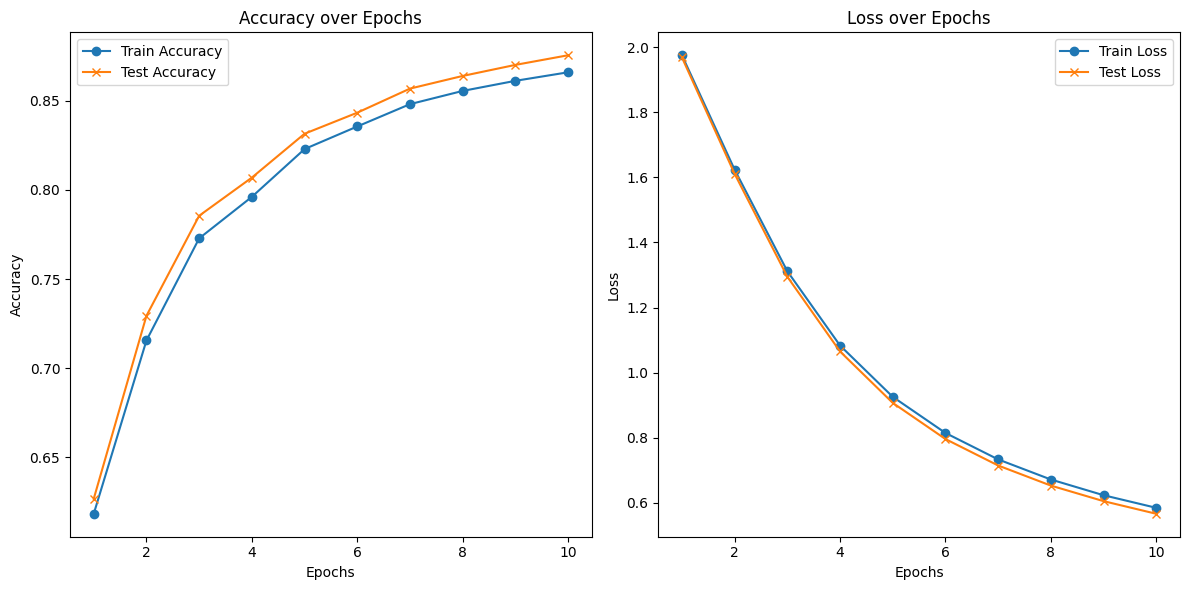

In [115]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, 
          epochs=10, batch_size=128, optimizer='momentum', l_rate=0.01, beta1=0.9,beta2= 0.999)

Epoch 1/10 - Train Loss: 0.8062, Train Acc: 0.8367, Test Loss: 0.7830, Test Acc: 0.8467
Epoch 2/10 - Train Loss: 0.5252, Train Acc: 0.8686, Test Loss: 0.5037, Test Acc: 0.8767
Epoch 3/10 - Train Loss: 0.4401, Train Acc: 0.8823, Test Loss: 0.4208, Test Acc: 0.8892
Epoch 4/10 - Train Loss: 0.3978, Train Acc: 0.8910, Test Loss: 0.3798, Test Acc: 0.8971
Epoch 5/10 - Train Loss: 0.3720, Train Acc: 0.8963, Test Loss: 0.3546, Test Acc: 0.9027
Epoch 6/10 - Train Loss: 0.3531, Train Acc: 0.9008, Test Loss: 0.3374, Test Acc: 0.9062
Epoch 7/10 - Train Loss: 0.3388, Train Acc: 0.9046, Test Loss: 0.3240, Test Acc: 0.9098
Epoch 8/10 - Train Loss: 0.3278, Train Acc: 0.9071, Test Loss: 0.3147, Test Acc: 0.9115
Epoch 9/10 - Train Loss: 0.3176, Train Acc: 0.9104, Test Loss: 0.3052, Test Acc: 0.9164
Epoch 10/10 - Train Loss: 0.3095, Train Acc: 0.9125, Test Loss: 0.2980, Test Acc: 0.9174


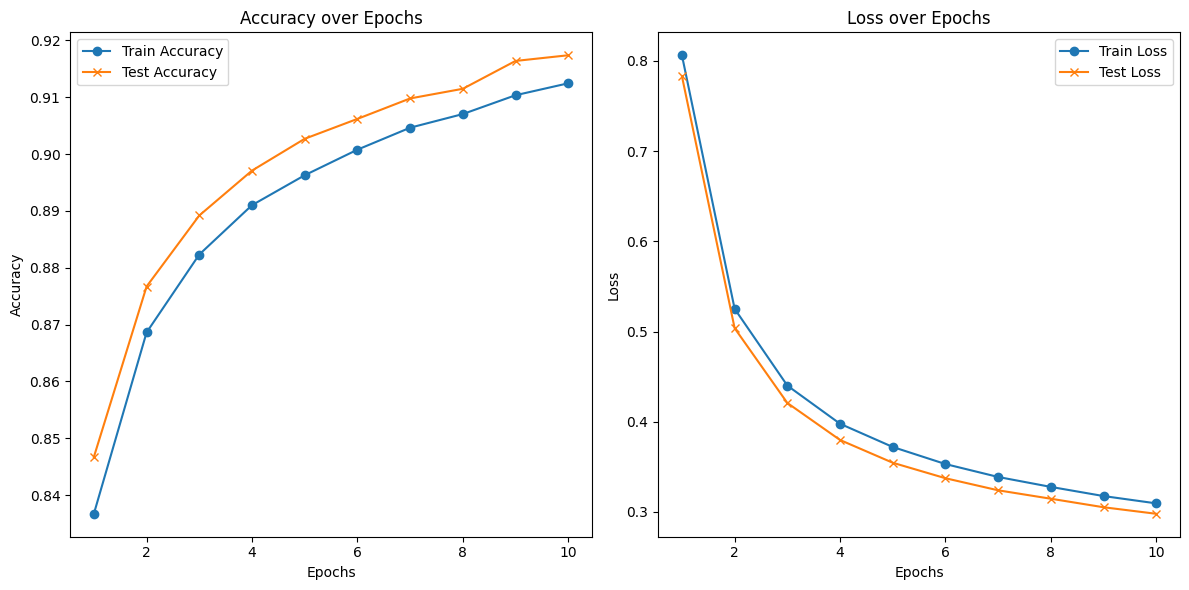

In [116]:
# ReLU + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, 
          epochs=10, batch_size=128, optimizer='momentum', l_rate=0.01, beta1=0.9, beta2=0.999)


Epoch 1/10 - Train Loss: 0.3797, Train Acc: 0.9049, Test Loss: 0.3703, Test Acc: 0.9063
Epoch 2/10 - Train Loss: 0.2727, Train Acc: 0.9253, Test Loss: 0.2708, Test Acc: 0.9247
Epoch 3/10 - Train Loss: 0.2271, Train Acc: 0.9382, Test Loss: 0.2265, Test Acc: 0.9356
Epoch 4/10 - Train Loss: 0.1972, Train Acc: 0.9454, Test Loss: 0.2007, Test Acc: 0.9426
Epoch 5/10 - Train Loss: 0.1746, Train Acc: 0.9511, Test Loss: 0.1807, Test Acc: 0.9486
Epoch 6/10 - Train Loss: 0.1555, Train Acc: 0.9566, Test Loss: 0.1626, Test Acc: 0.9527
Epoch 7/10 - Train Loss: 0.1413, Train Acc: 0.9611, Test Loss: 0.1516, Test Acc: 0.9566
Epoch 8/10 - Train Loss: 0.1280, Train Acc: 0.9640, Test Loss: 0.1414, Test Acc: 0.9587
Epoch 9/10 - Train Loss: 0.1169, Train Acc: 0.9675, Test Loss: 0.1330, Test Acc: 0.9619
Epoch 10/10 - Train Loss: 0.1082, Train Acc: 0.9704, Test Loss: 0.1271, Test Acc: 0.9635


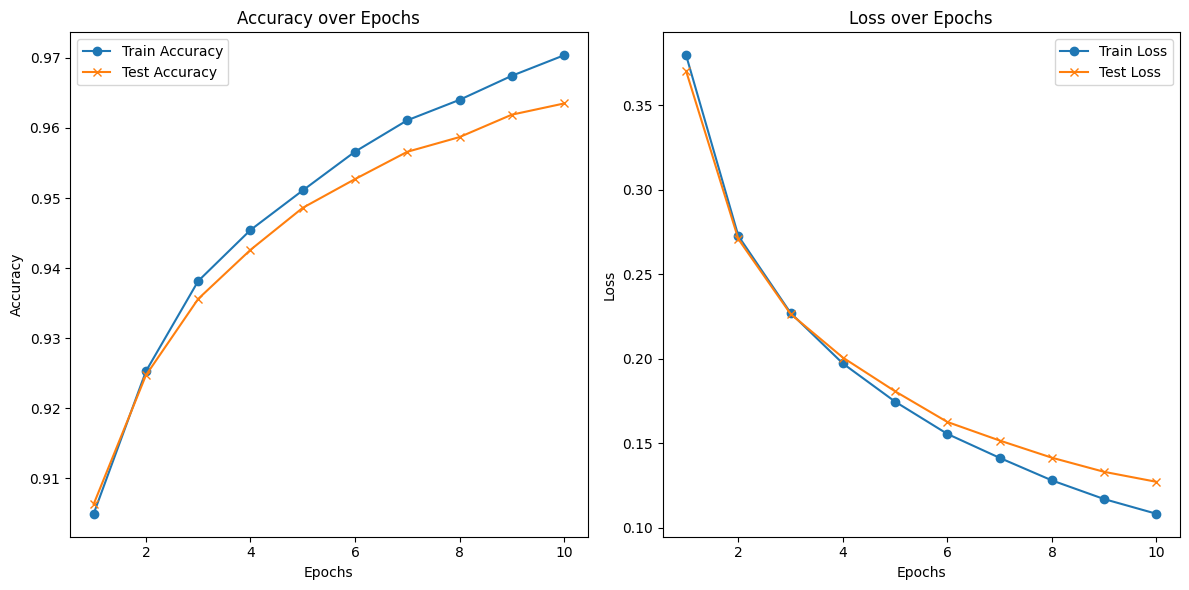

In [117]:
# Sigmoid + Adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, 
          epochs=10, batch_size=128, optimizer='adam', l_rate=0.001, beta1=0.9, beta2=0.999)


Epoch 1/10 - Train Loss: 0.2386, Train Acc: 0.9325, Test Loss: 0.2361, Test Acc: 0.9317
Epoch 2/10 - Train Loss: 0.1809, Train Acc: 0.9478, Test Loss: 0.1842, Test Acc: 0.9441
Epoch 3/10 - Train Loss: 0.1529, Train Acc: 0.9554, Test Loss: 0.1624, Test Acc: 0.9522
Epoch 4/10 - Train Loss: 0.1179, Train Acc: 0.9672, Test Loss: 0.1314, Test Acc: 0.9620
Epoch 5/10 - Train Loss: 0.1020, Train Acc: 0.9705, Test Loss: 0.1225, Test Acc: 0.9647
Epoch 6/10 - Train Loss: 0.0858, Train Acc: 0.9754, Test Loss: 0.1122, Test Acc: 0.9668
Epoch 7/10 - Train Loss: 0.0781, Train Acc: 0.9772, Test Loss: 0.1057, Test Acc: 0.9687
Epoch 8/10 - Train Loss: 0.0671, Train Acc: 0.9812, Test Loss: 0.1008, Test Acc: 0.9714
Epoch 9/10 - Train Loss: 0.0631, Train Acc: 0.9825, Test Loss: 0.0987, Test Acc: 0.9706
Epoch 10/10 - Train Loss: 0.0533, Train Acc: 0.9849, Test Loss: 0.0907, Test Acc: 0.9731


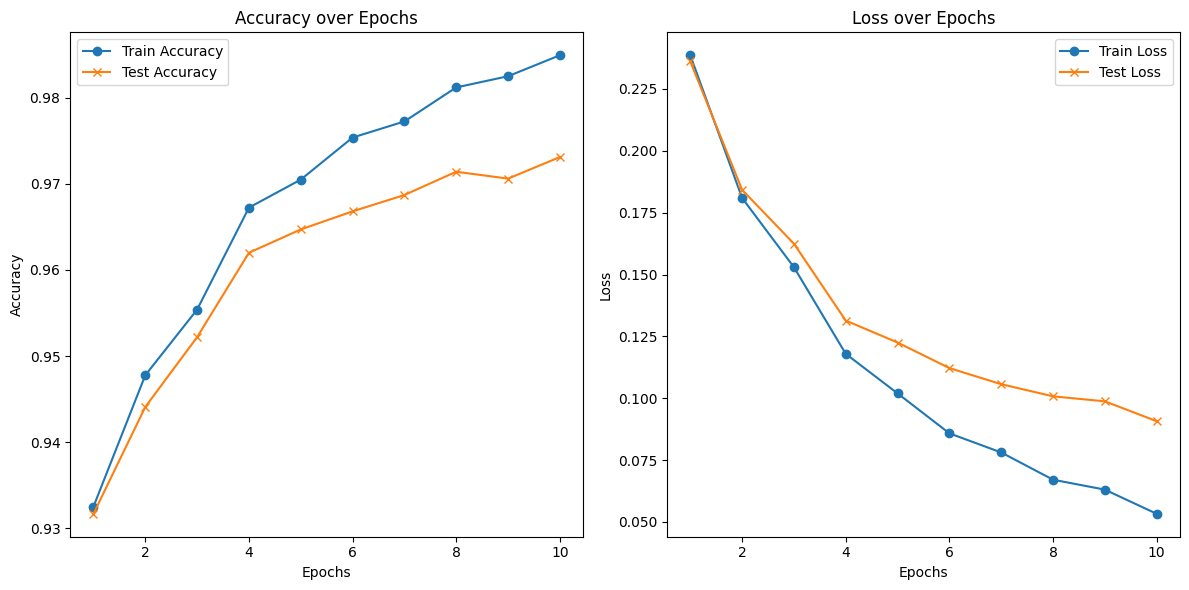

In [118]:
# ReLU + Adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, 
          epochs=10, batch_size=128, optimizer='adam', l_rate=0.001, beta1=0.9, beta2=0.999)


Epoch 1/10 - Train Loss: 0.2390, Train Acc: 0.9321, Test Loss: 0.2412, Test Acc: 0.9311
Epoch 2/10 - Train Loss: 0.1952, Train Acc: 0.9444, Test Loss: 0.2015, Test Acc: 0.9424
Epoch 3/10 - Train Loss: 0.1657, Train Acc: 0.9534, Test Loss: 0.1755, Test Acc: 0.9471
Epoch 4/10 - Train Loss: 0.1464, Train Acc: 0.9591, Test Loss: 0.1578, Test Acc: 0.9532
Epoch 5/10 - Train Loss: 0.1328, Train Acc: 0.9628, Test Loss: 0.1480, Test Acc: 0.9565
Epoch 6/10 - Train Loss: 0.1198, Train Acc: 0.9669, Test Loss: 0.1370, Test Acc: 0.9602
Epoch 7/10 - Train Loss: 0.1104, Train Acc: 0.9687, Test Loss: 0.1301, Test Acc: 0.9619
Epoch 8/10 - Train Loss: 0.1005, Train Acc: 0.9723, Test Loss: 0.1224, Test Acc: 0.9635
Epoch 9/10 - Train Loss: 0.0937, Train Acc: 0.9747, Test Loss: 0.1179, Test Acc: 0.9657
Epoch 10/10 - Train Loss: 0.0866, Train Acc: 0.9759, Test Loss: 0.1136, Test Acc: 0.9659


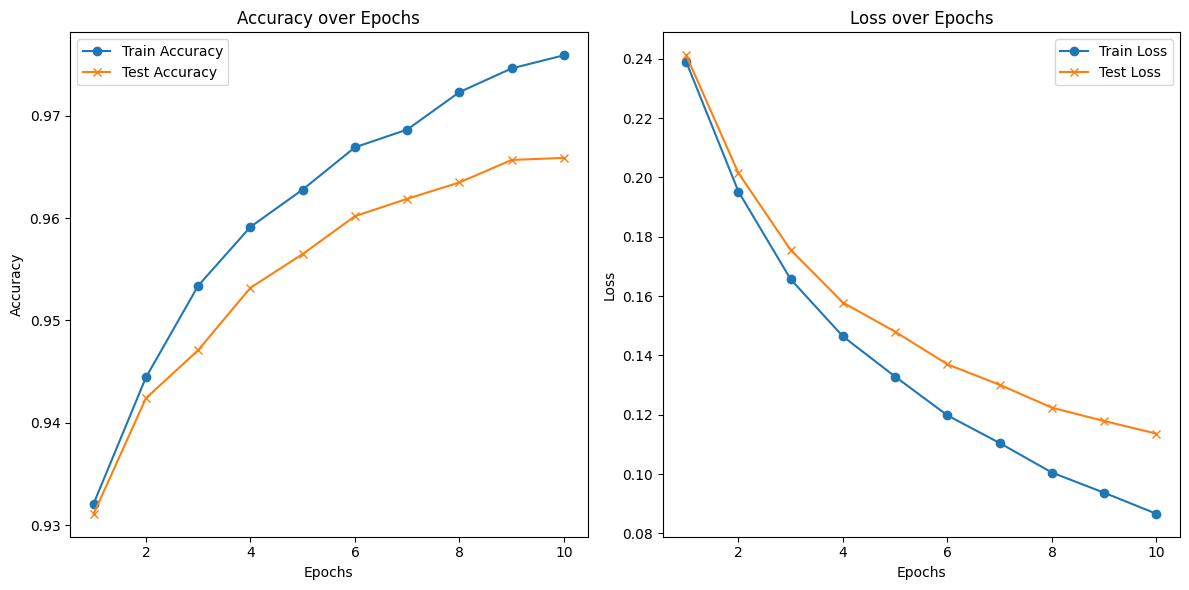

In [119]:
# Sigmoid + RMSProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, 
          epochs=10, batch_size=128, optimizer='rmsprop', l_rate=0.001, beta2=0.999)


Epoch 1/10 - Train Loss: 0.1749, Train Acc: 0.9498, Test Loss: 0.1786, Test Acc: 0.9469
Epoch 2/10 - Train Loss: 0.1291, Train Acc: 0.9634, Test Loss: 0.1386, Test Acc: 0.9593
Epoch 3/10 - Train Loss: 0.1031, Train Acc: 0.9699, Test Loss: 0.1176, Test Acc: 0.9640
Epoch 4/10 - Train Loss: 0.0858, Train Acc: 0.9754, Test Loss: 0.1016, Test Acc: 0.9686
Epoch 5/10 - Train Loss: 0.0754, Train Acc: 0.9784, Test Loss: 0.0979, Test Acc: 0.9702
Epoch 6/10 - Train Loss: 0.0659, Train Acc: 0.9808, Test Loss: 0.0890, Test Acc: 0.9726
Epoch 7/10 - Train Loss: 0.0588, Train Acc: 0.9832, Test Loss: 0.0867, Test Acc: 0.9727
Epoch 8/10 - Train Loss: 0.0510, Train Acc: 0.9860, Test Loss: 0.0800, Test Acc: 0.9751
Epoch 9/10 - Train Loss: 0.0447, Train Acc: 0.9878, Test Loss: 0.0797, Test Acc: 0.9750
Epoch 10/10 - Train Loss: 0.0460, Train Acc: 0.9865, Test Loss: 0.0823, Test Acc: 0.9734


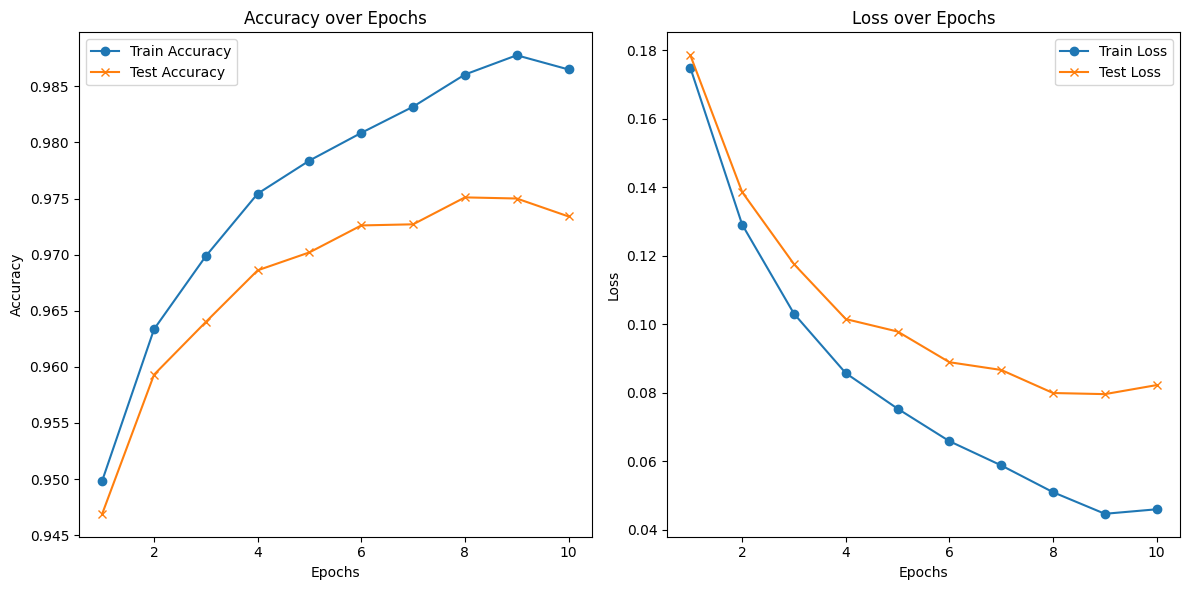

In [120]:
# ReLU + RMSProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, 
          epochs=10, batch_size=128, optimizer='rmsprop', l_rate=0.001, beta2=0.999)
